# AnSeqData Project

### Nanchen Jean - Zimmermann Thomas

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [28]:
# Open dataset with column names as in gridwatch.csv
df = pd.read_csv('gridwatch.csv', header=0, delimiter=",", names=['timestamp', 'demand', 'frequency', 'coal', 'nuclear', 'ccgt', 'wind', 'pumped', 'hydro', 'biomass', 'solar'])

# Keep only timestamp and coal columns
df = df[['timestamp', 'coal']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.shape)
df.head()


(796453, 2)


,timestamp,coal
62694,2012-01-01 00:00:01,8693
62695,2012-01-01 00:05:06,8650
62696,2012-01-01 00:10:01,8880
62697,2012-01-01 00:15:01,9111
62698,2012-01-01 00:20:01,9195


<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

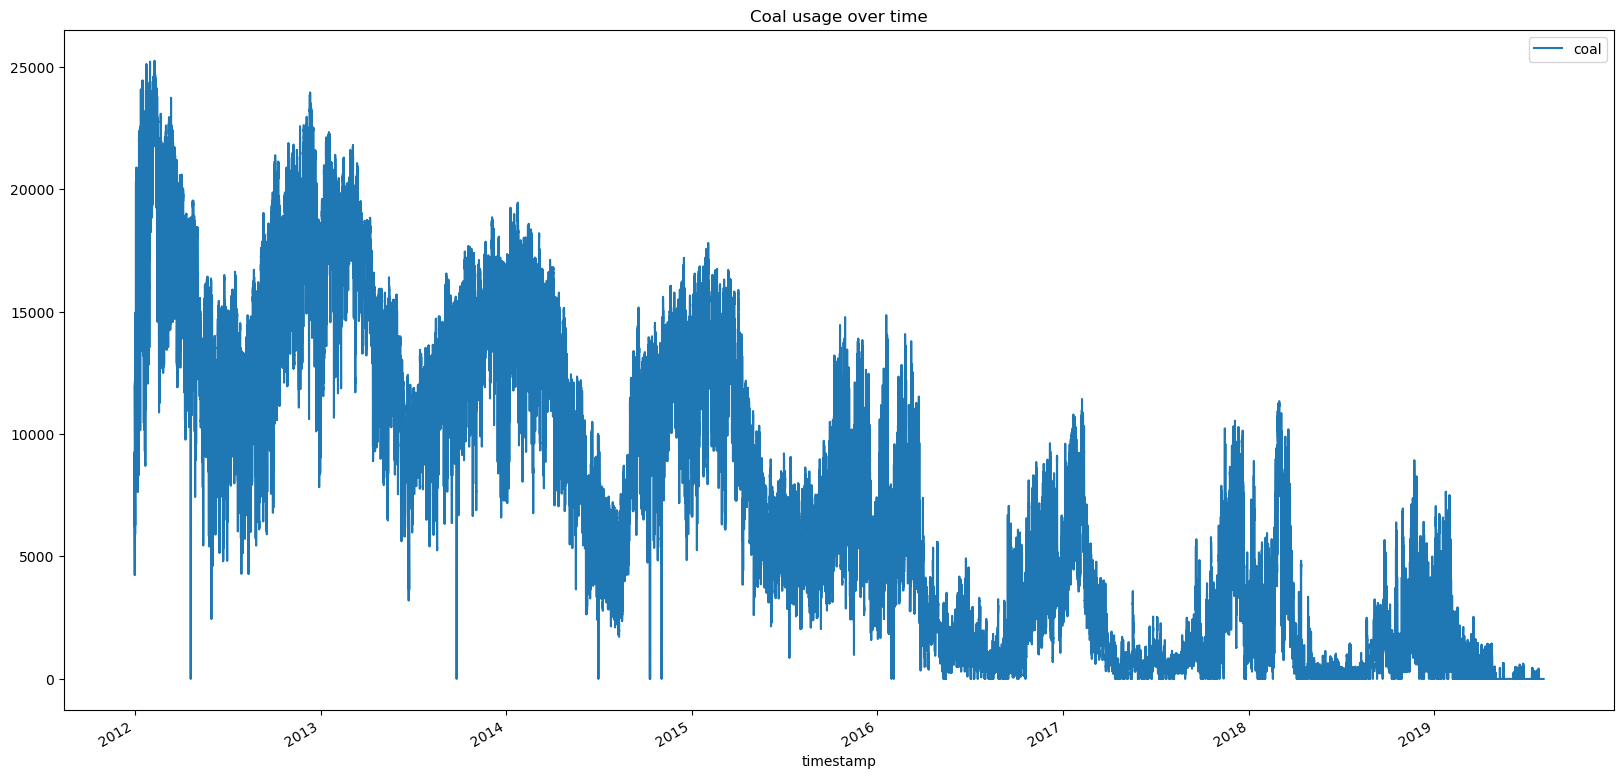

In [29]:
# Plot the coal usage column over time 
df.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time')


Saisonalité -> usage intesif en hiver, beaucoup moins en été. Tendance à la baisse overall

In [30]:
# Pre-process coal data to get the average coal usage per day
dfDay = df
dfDay = dfDay.set_index('timestamp')
dfDay = dfDay.resample('D').mean()
dfDay = dfDay.reset_index()
print(dfDay.shape)
dfDay.head()

(2772, 2)


,timestamp,coal
0,2012-01-01,8501.128472
1,2012-01-02,10203.655052
2,2012-01-03,15384.989583
3,2012-01-04,17026.888889
4,2012-01-05,16545.250000


<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

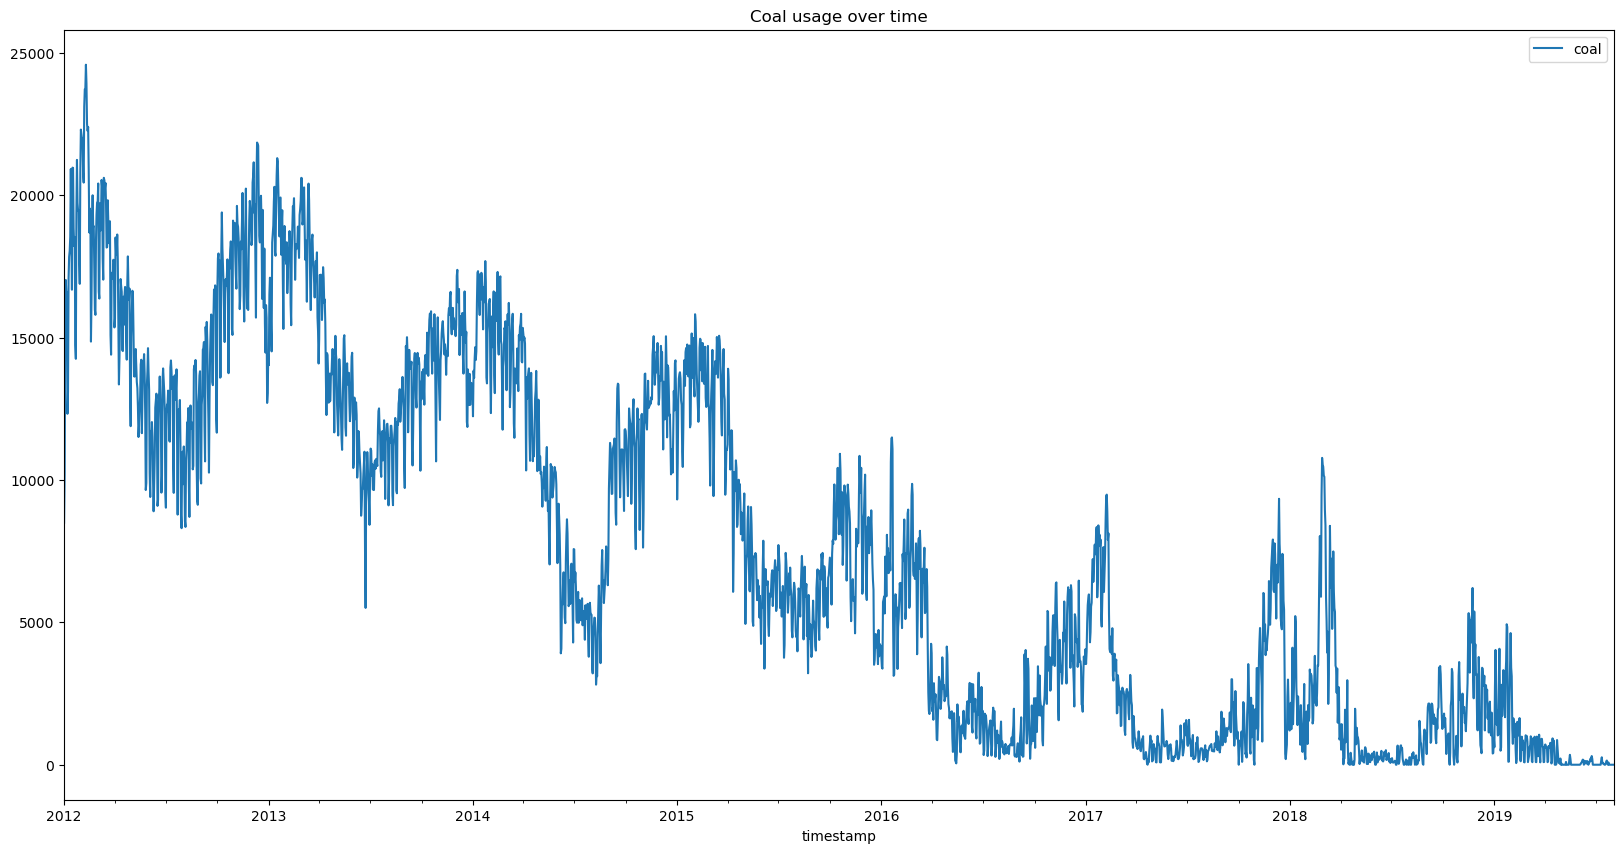

In [31]:
dfDay.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time')

On s'assure qu'on perd pas d'infos importantes en moyennant par jour

<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

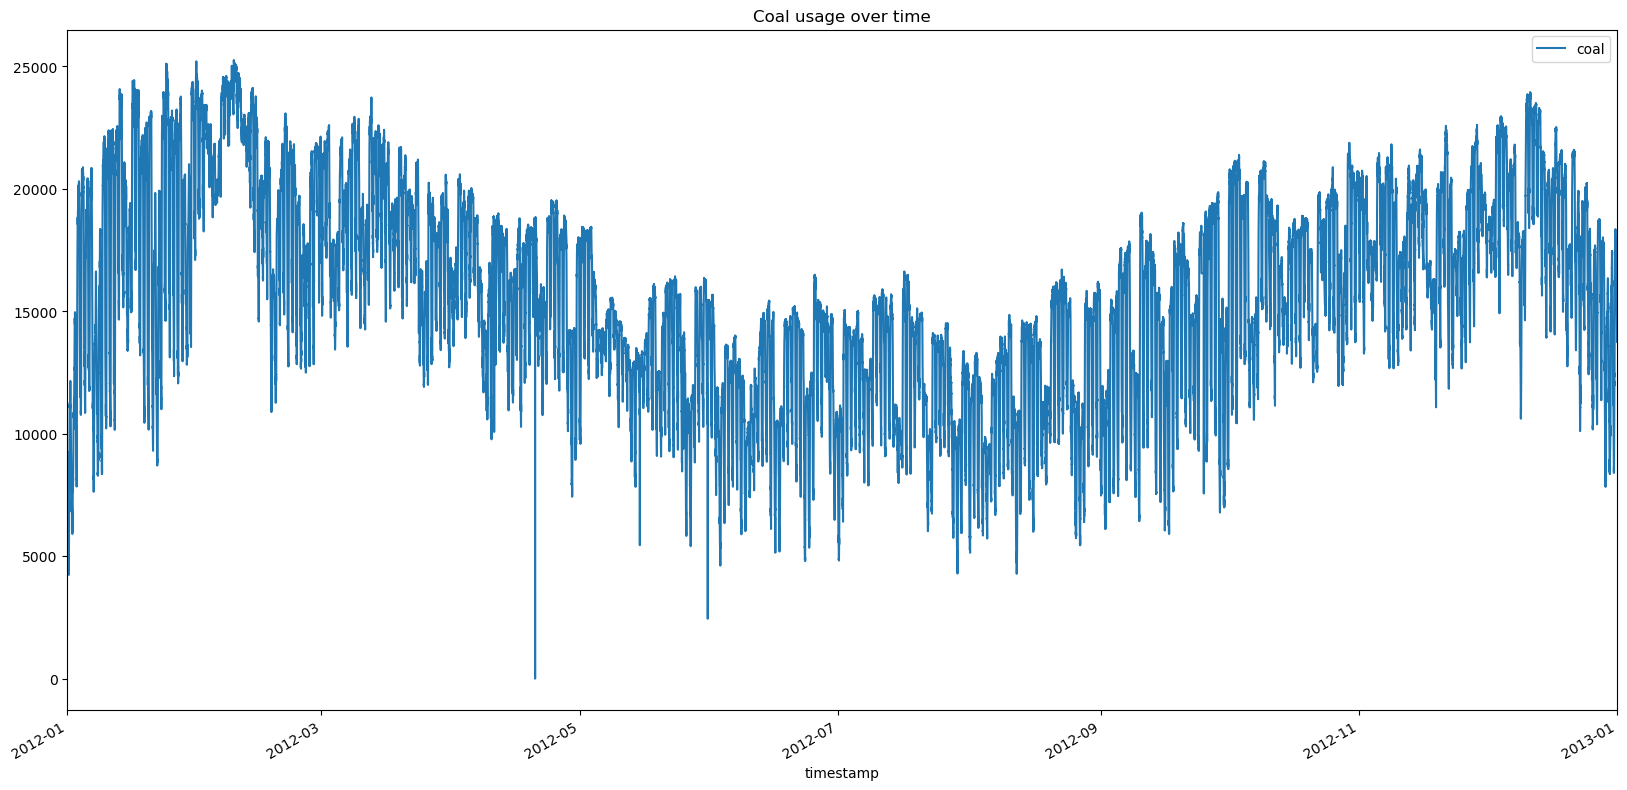

In [32]:
# Plot the first year of coal usage
df.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time', xlim=['2012-01-01', '2013-01-01'])

On voit qu'il y a aussi une saisonaité journalière -> zoom sur ca

<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

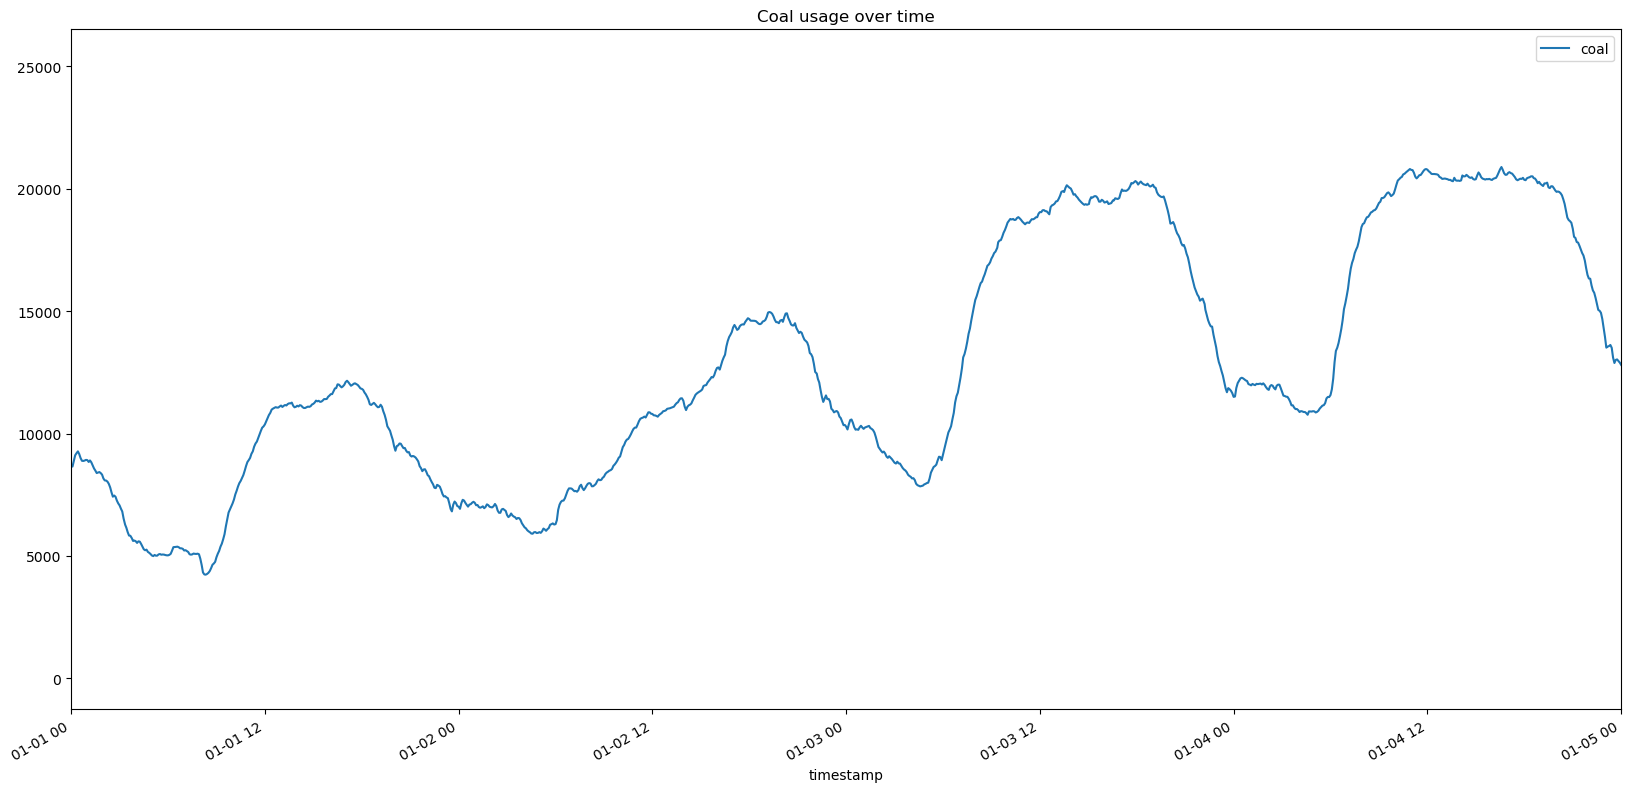

In [33]:
# Plot the first month of coal usage vs hour of day
df.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time', xlim=['2012-01-01', '2012-01-05'])


Sympa de remarquer mais surement pas très important pour l'analyse parce qu'on analyse sur des + longues périodes -> La saisonalité annuelle est plus intéressante que la saisonalité journalière, a partir d'ici pour les analyses on utilise dfDay plutot que df

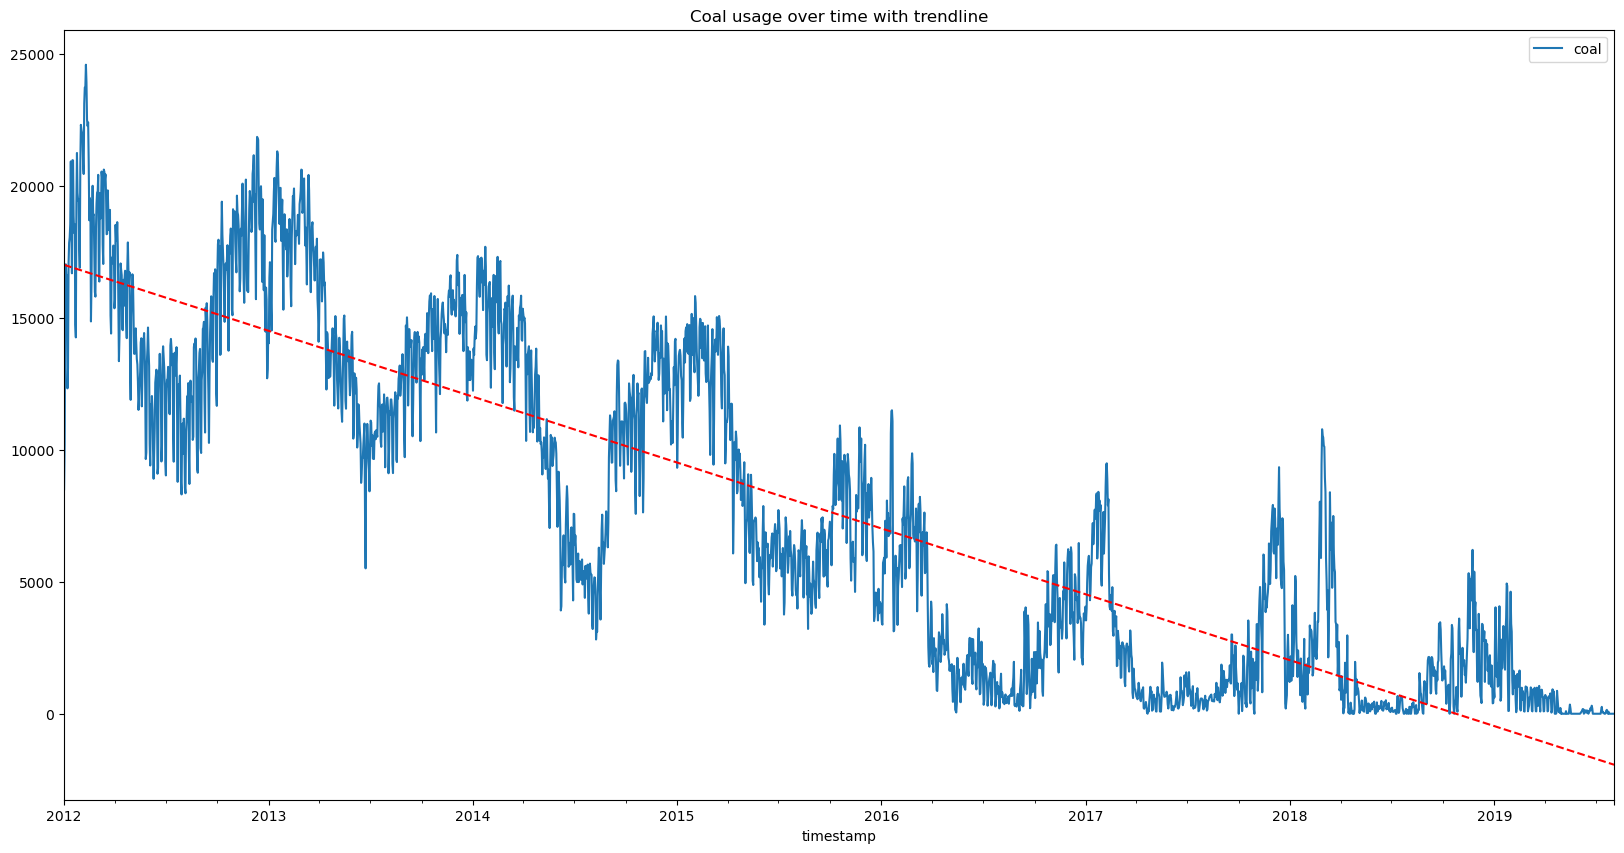

In [34]:
# Generate trendline for coal usage over time
# calc the trendline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
x = mdates.date2num(dfDay['timestamp'])
y= dfDay['coal']
z = np.polyfit(x, dfDay['coal'], 1)
p = np.poly1d(z)
#then the plot
dfDay.plot('timestamp', 'coal', figsize=(20, 10), title='Coal usage over time with trendline')
plt.plot(x, p(x), "r--")



La trendline nous indique clairement une tendance baissière (qu'on appercevait déjà à l'oeil nu mais là au moins c'est officiel)

# Cropping dataset

(1461, 2)
(1311, 2)


C:\Users\jean.nanchen\AppData\Local\Temp\ipykernel_20340\791079437.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


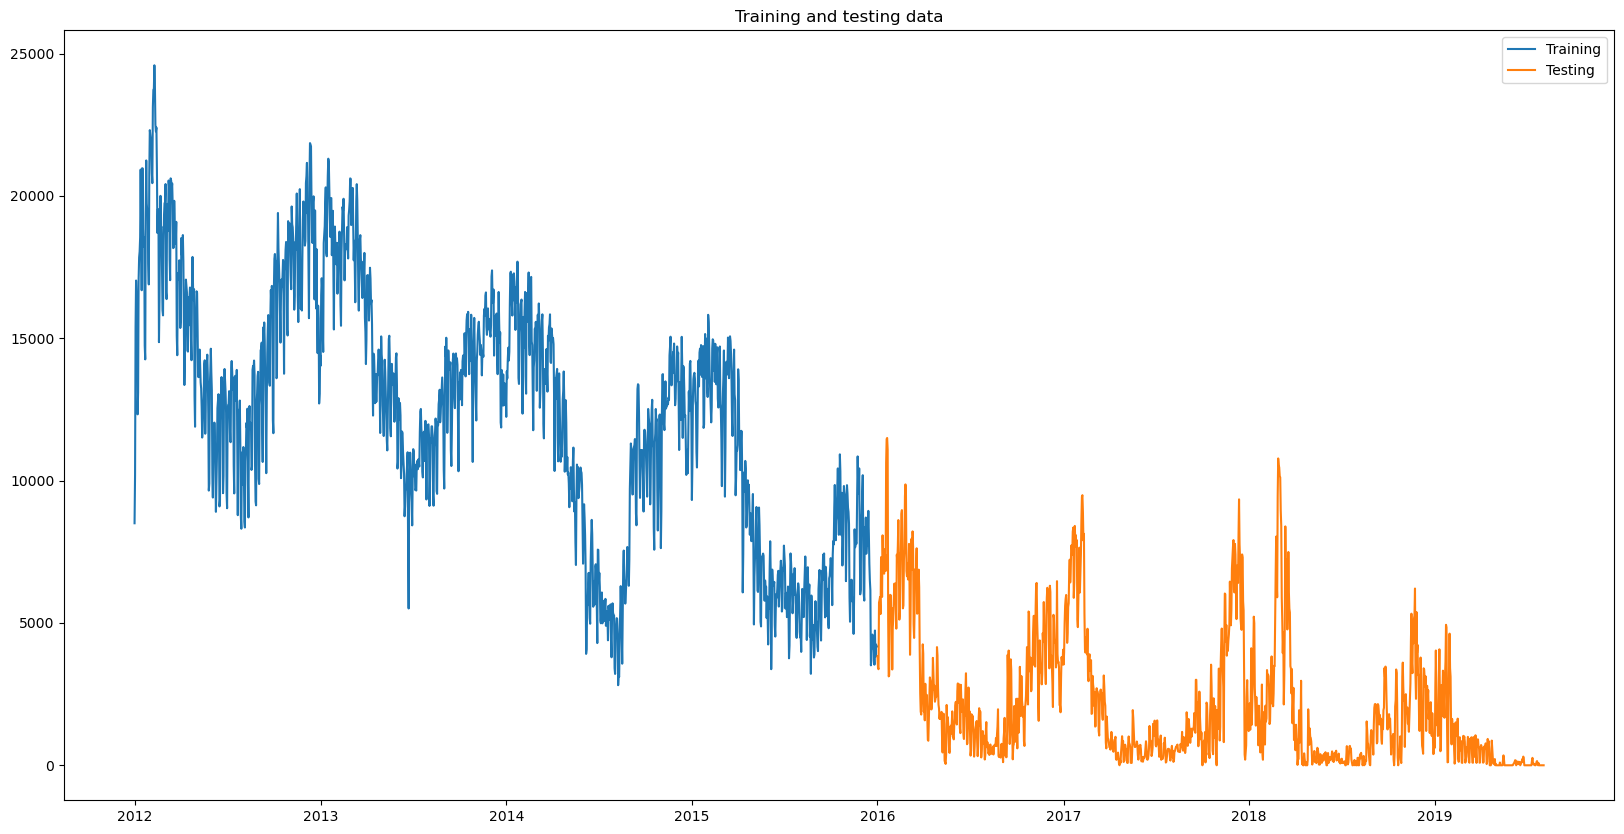

In [35]:
# Separate the dfDay dataframe into two dataframes, one for training and one for testing
dfDayTrain = dfDay[dfDay['timestamp'] < '2016-01-01']
dfDayTest = dfDay[dfDay['timestamp'] >= '2016-01-01']
print(dfDayTrain.shape)
print(dfDayTest.shape)

# Plot the training and testing dataframes with matplotlib
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain['timestamp'], dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], dfDayTest['coal'], label='Testing')
ax.set_title('Training and testing data')
ax.legend()
fig.show()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\jean.nanchen\AppData\Local\Temp\ipykernel_20340\4129799690.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


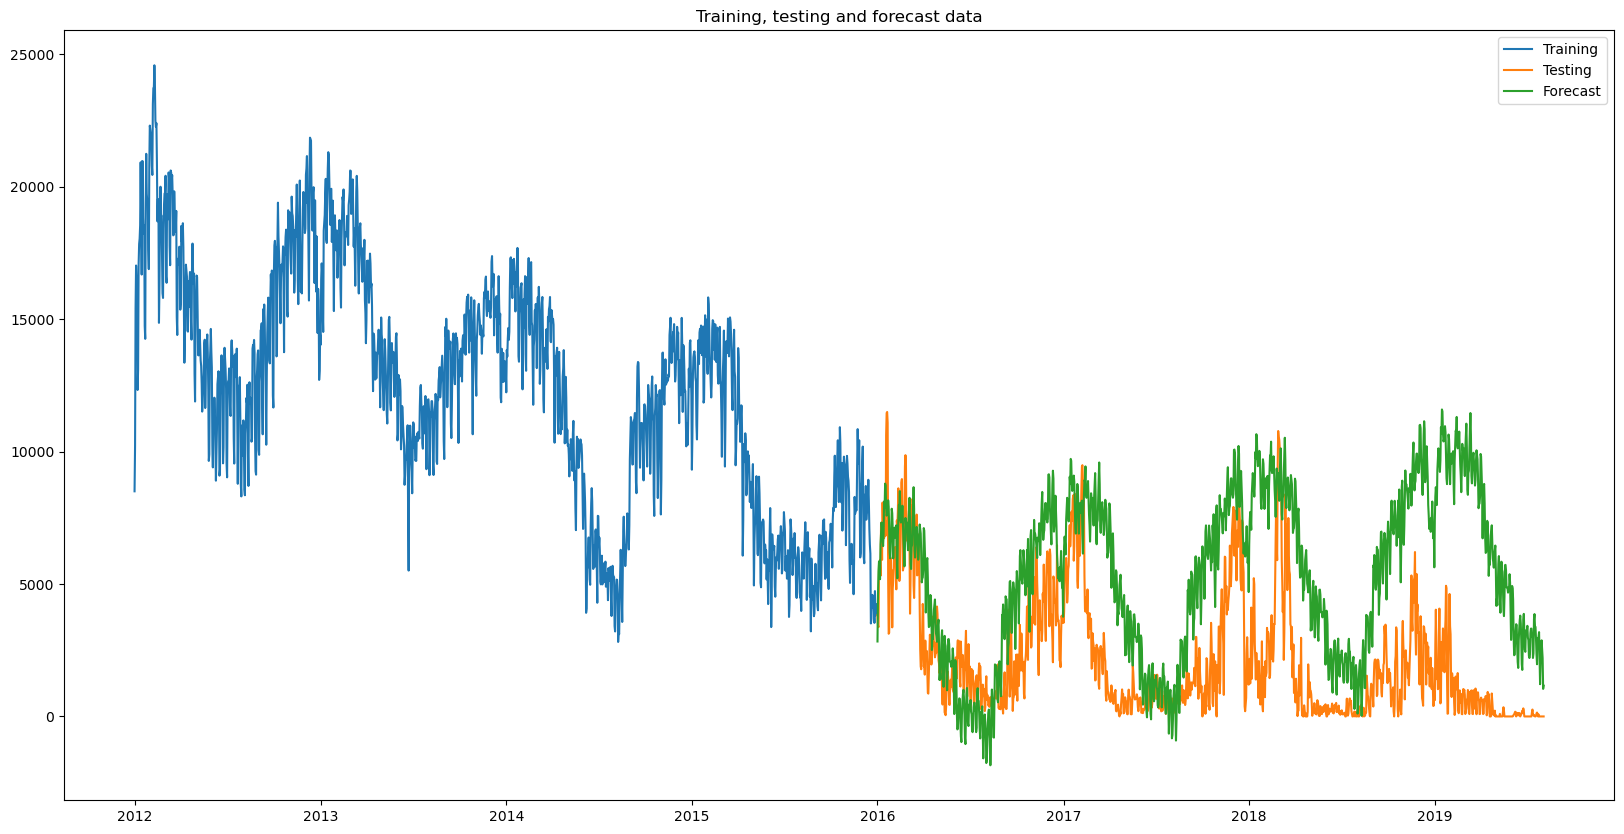

In [36]:
# We want to forecast the coal usage for the next days based on the length of the testing dataframe

from statsmodels.tsa.api import ExponentialSmoothing

# Fit the model
model = ExponentialSmoothing(dfDayTrain['coal'], seasonal_periods=365, trend='add', seasonal='add').fit(optimized=True)

# Forecast the next days based on the length of the testing dataframe
forecast = model.forecast(len(dfDayTest))

# Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain['timestamp'], dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], dfDayTest['coal'], label='Testing')
ax.plot(dfDayTest['timestamp'], forecast, label='Forecast')
ax.set_title('Training, testing and forecast data')
ax.legend()
fig.show()




c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


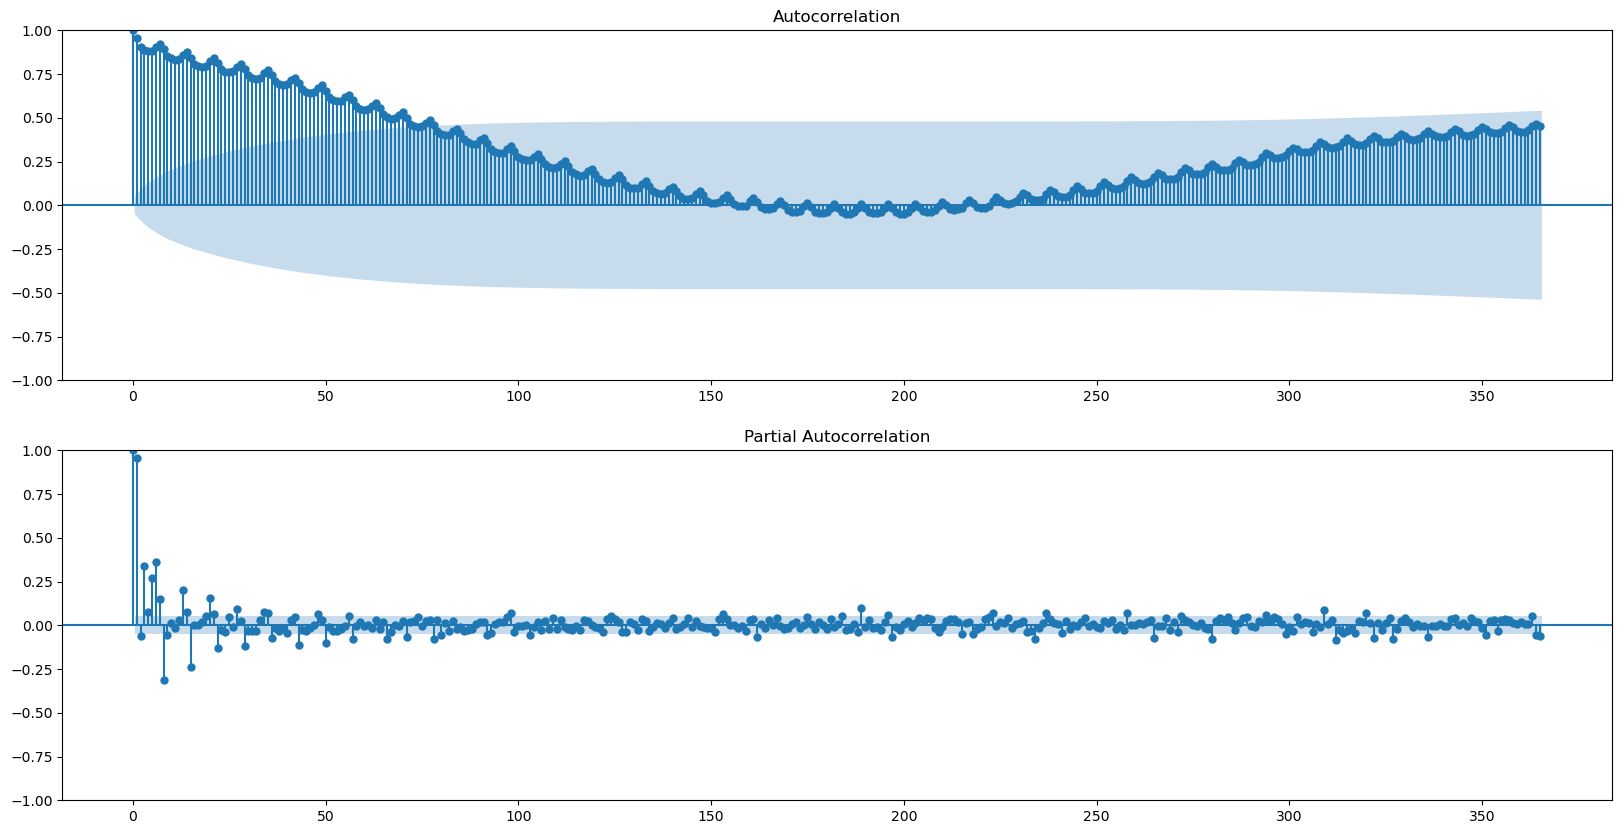

In [37]:
# Do a ACF and PACF plot to determine the order of the ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Make two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
# Plot the ACF
plot_acf(dfDayTrain['coal'], lags=365, ax=ax1)
# Plot the PACF
plot_pacf(dfDayTrain['coal'], lags=365, ax=ax2)
plt.show()



On remarque que ce n'est pas stationnaire, on a une tendance vers le bas... On peut le savoir car ici en bas je calcule le p-value et si = 0 = stationnaire

In [38]:
# Test ADF
from statsmodels.tsa.stattools import adfuller
result = adfuller(dfDayTrain['coal'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic: -1.554461
p-value: 0.506419
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [56]:
# Diff and dropna to make the data stationary
dfDayTrainDiff = dfDayTrain
dfDayTrainDiff["coal"] = dfDayTrainDiff["coal"].diff().dropna()
dfDayTrainDiff.head()
# Drop NaN values
dfDayTrainDiff = dfDayTrainDiff.dropna()
dfDayTrainDiff.head()
print(dfDayTrainDiff.shape)


(1456, 2)


C:\Users\jean.nanchen\AppData\Local\Temp\ipykernel_20340\2132433988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfDayTrainDiff["coal"] = dfDayTrainDiff["coal"].diff().dropna()


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


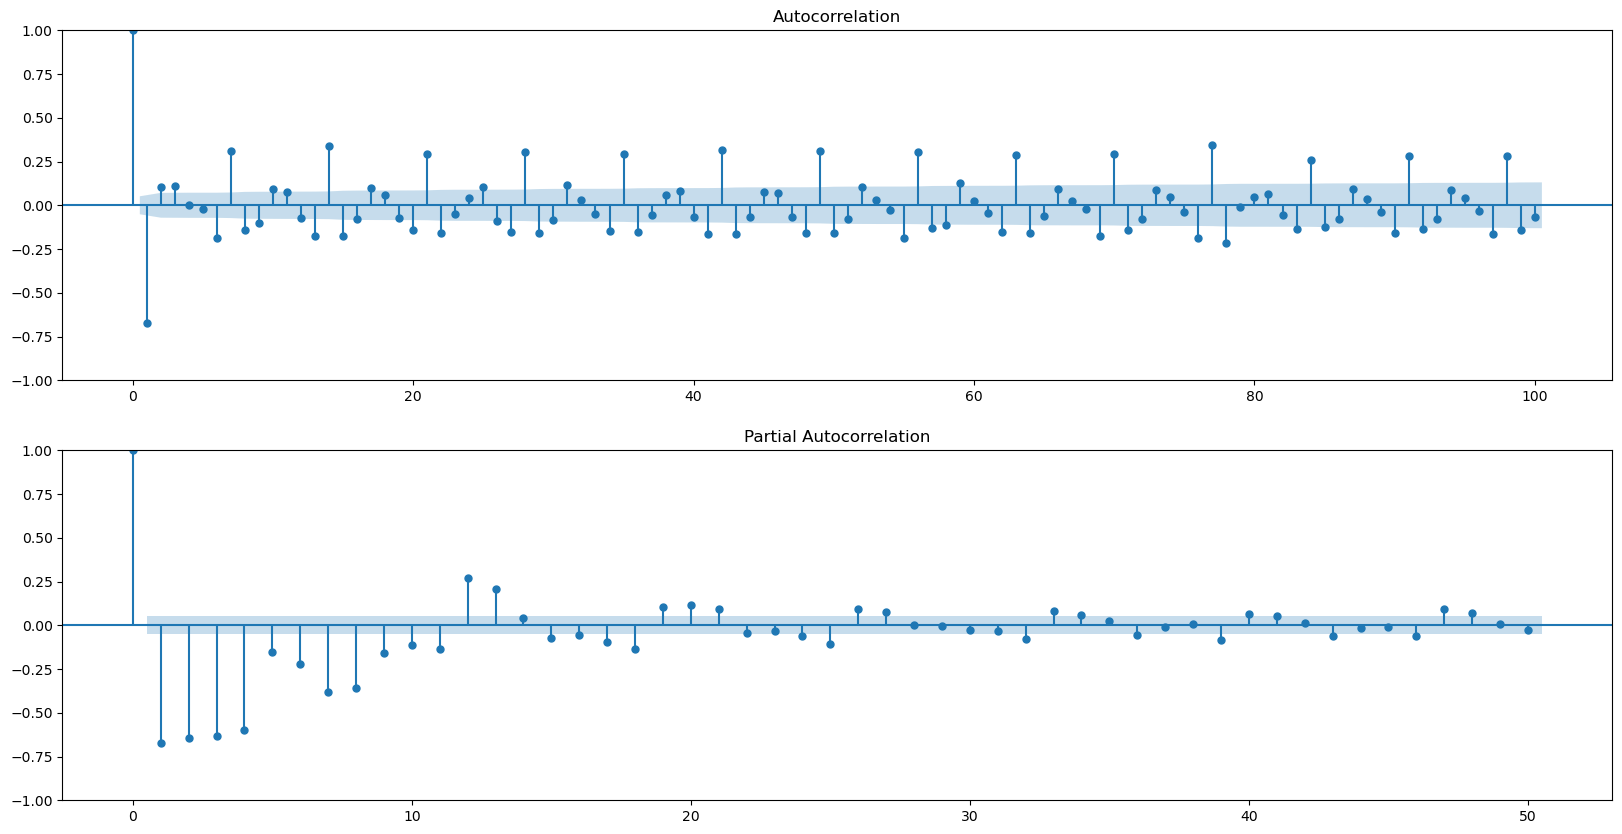

ADF Statistic: -23.022272
p-value: 0.000000


In [57]:
# Replot the ACF and PACF to determine the order of the ARIMA model
# Make two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
# Plot the ACF
plot_acf(dfDayTrainDiff["coal"], lags=100, ax=ax1)
# Plot the PACF
plot_pacf(dfDayTrainDiff["coal"], lags=50, ax=ax2)
plt.show()

# Test ADF
from statsmodels.tsa.stattools import adfuller
result = adfuller(dfDayTrainDiff["coal"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


### On voit sur le plot du haut que pour le PACF on devient dans la plage vers la 25ème et pour le ACF vers 400 ducoup j'ai déterminé p = 25 et q = 365

In [41]:
# Determine p q and d values for the ARIMA model

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   coal   No. Observations:                 1461
Model:               ARIMA(25, 1, 20)   Log Likelihood              -12633.216
Date:                Mon, 05 Dec 2022   AIC                          25358.432
Time:                        18:30:39   BIC                          25601.596
Sample:                             0   HQIC                         25449.142
                               - 1461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.0173      0.052    -57.800      0.000      -3.120      -2.915
ar.L2         -4.0791      0.173    -23.616      0.000      -4.418      -3.741
ar.L3         -3.5097      0.291    -12.075      0.0

C:\Users\jean.nanchen\AppData\Local\Temp\ipykernel_20340\2072555169.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


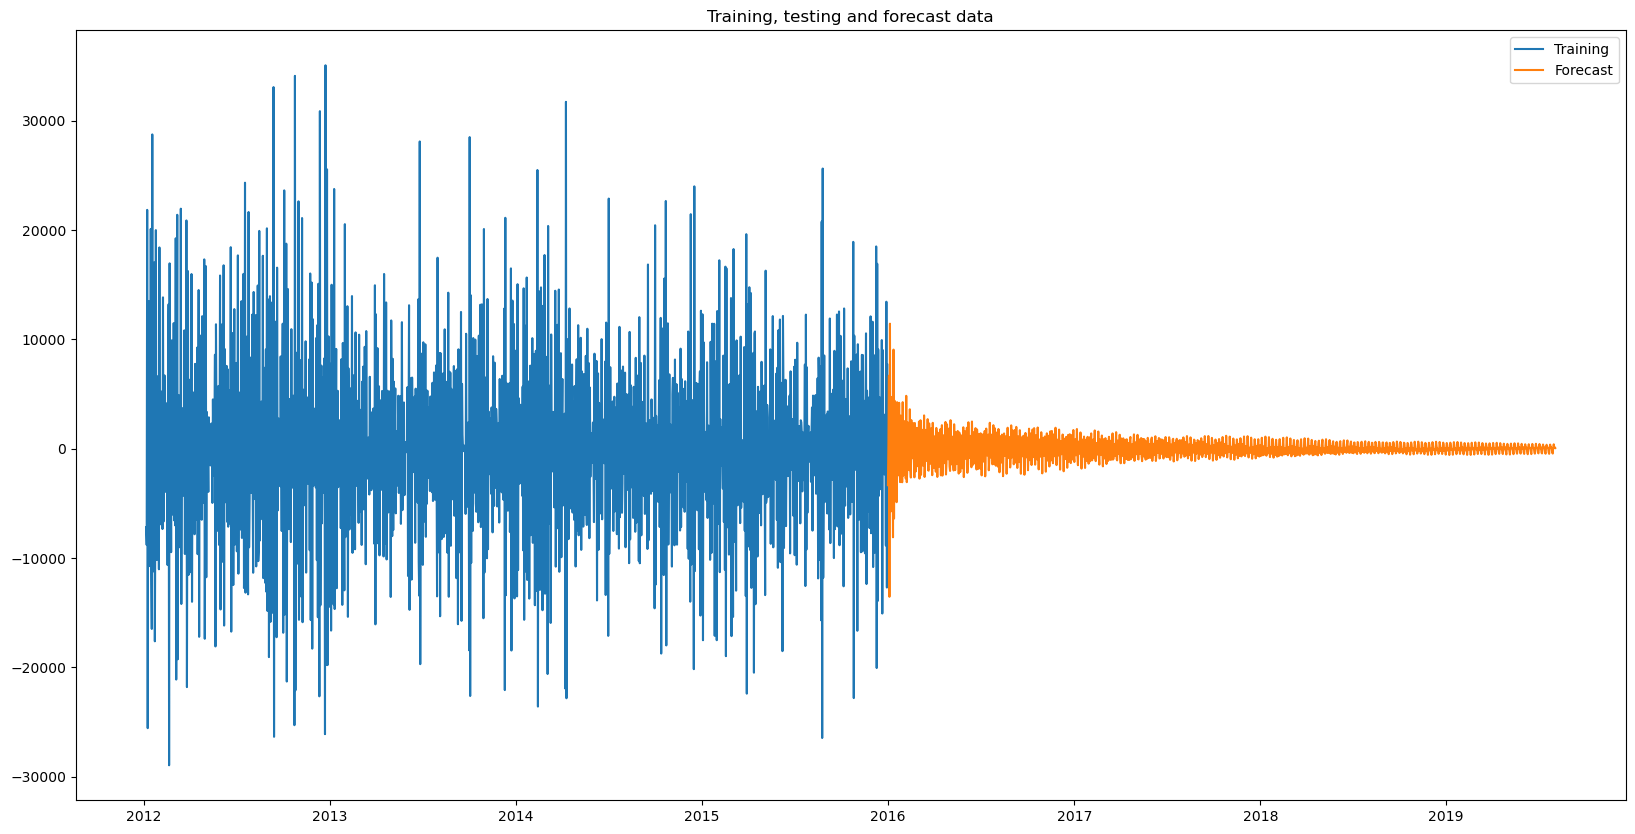

In [62]:
# Forecast the next days based on the length of the testing dataframe with ARMIA model
# Auto determine the order of the model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(dfDayTrain['coal'], order=(25, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

# Forecast the next days based on the length of the testing dataframe
forecast = model_fit.forecast(steps=len(dfDayTest))



# Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrainDiff['timestamp'], dfDayTrainDiff['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], forecast, label='Forecast')
ax.set_title('Training, testing and forecast data')
ax.legend()
fig.show()


